In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold


In [2]:
import scanpy as sc

# read the full GSE dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
# data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data = sc.read_h5ad('/ws/Research_datasets/GSE164378/Hao_PBMC_GSE164378.h5ad')
data.shape

(161764, 33538)

In [3]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [4]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [5]:
# Level 1 ADlasso features by loss difference convergence
import os
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\feature_selection")
os.chdir('/ws/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


## SVM

In [ ]:
celltype = 'B'
# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced')
svm_clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = svm_clf.predict(X_test)
# y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
pr_auc = average_precision_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
metrics

## Stratified K-fold

In [8]:
import pickle

def SVM_strat_KFold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    print('Fitting SVM model...')
    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced', max_iter=5000)
    svm_clf.fit(X_train, y_train)

    scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score),
    'pr_auc': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cv_results = cross_validate(svm_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    # return cv_results

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_pr_auc'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]
    
    return svm_clf, mean_metrics




In [9]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/SVM_classifiers_all')
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\SVM_classifiers_all")
os.chdir('/ws/GitHub/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/SVM_classifiers_all')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = SVM_strat_KFold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output SVM model as pickle
    filename = f'SVM_{celltype}_loss_diff_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.9973031731066178, 0.9744185257927949, 0.9945652173913044, 0.984373995421142, 0.9960618737549464, 0.9695961825849357, 0.982968951136081]
K-fold CV for: CD4_T


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.7749492995118168, 0.566171079074238, 0.7092467778930189, 0.6234553040732174, 0.7532518953123102, 0.4749442549043149, 0.4796105426258312]
K-fold CV for: CD8_T


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.6622464515450149, 0.2862423835755613, 0.6832883435582822, 0.3950385877719985, 0.6708015007510622, 0.25249090443918315, 0.26382376649825917]
K-fold CV for: DC


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.969909802841156, 0.46035847872266017, 0.8663069231934557, 0.5896547893997844, 0.9192843293065429, 0.4051190230914886, 0.6129043646837785]
K-fold CV for: Mono


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.9821575812930968, 0.9590178794903146, 0.9831157712741451, 0.9709027274965797, 0.982428461478673, 0.947960276913045, 0.9582085523483889]
K-fold CV for: NK


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.8130596794967305, 0.4873773992974907, 0.8298759235992718, 0.5928107415948722, 0.8203712252517672, 0.4572839906810041, 0.5382019653511382]
K-fold CV for: other


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.7200151700586097, 0.010100520353797847, 0.14340735852169612, 0.01880897679819466, 0.4379797757222246, 0.02019892719199095, -0.04241669489785927]
K-fold CV for: other_T


c:\Users\evanlee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.7908156670481732, 0.12617439183774665, 0.3301705574502618, 0.17605726687767514, 0.5705821330564746, 0.07849488551911489, 0.11642516877386724]


In [10]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.997303,0.974419,0.994565,0.984374,0.996062,0.969596,0.982969
CD4_T,0.774949,0.566171,0.709247,0.623455,0.753252,0.474944,0.479611
CD8_T,0.662246,0.286242,0.683288,0.395039,0.670802,0.252491,0.263824
DC,0.969910,0.460358,0.866307,0.589655,0.919284,0.405119,0.612904
Mono,0.982158,0.959018,0.983116,0.970903,0.982428,0.947960,0.958209
NK,0.813060,0.487377,0.829876,0.592811,0.820371,0.457284,0.538202
other,0.720015,0.010101,0.143407,0.018809,0.437980,0.020199,-0.042417
other_T,0.790816,0.126174,0.330171,0.176057,0.570582,0.078495,0.116425


In [11]:
!cd

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\SVM_classifiers_all


In [12]:
all_metrics.to_csv('SVM_metrics_loss_diff_l1_nostdscale.csv')

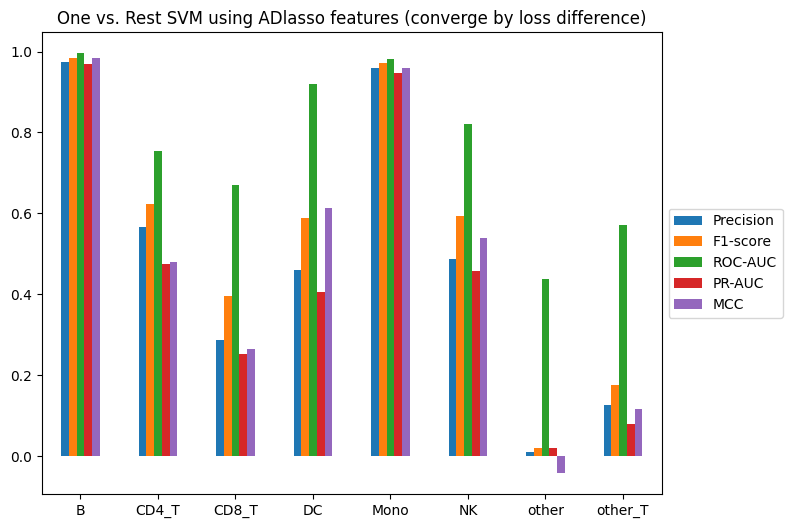

In [13]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest SVM using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Evaluate by DEGn

In [7]:
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


In [8]:
# Read DEG table
# os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")
os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L1_by_lossdiff\L1_DEG\L1_DEG_table")

# celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
# n_features = count_df.loc[celltype, 'Feature_count']  # 3902
# DEGn = DEG_table['names'][:n_features].tolist()

In [9]:
def SVM_classifier_DEG(data, DEGn, celltype):
    # subset data to celltype features
    X = data[:, DEGn].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    svm_clf = SVC(kernel='linear', decision_function_shape='ovr', class_weight='balanced')
    svm_clf.fit(X_train, y_train)

    # Predictions on the test set
    y_pred = svm_clf.predict(X_test)
    # y_score = svm_clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    metrics = [accuracy, precision, recall, f1, roc_auc, pr_auc, mcc]
    return svm_clf, metrics

In [10]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist() 
    clf, celltype_metrics = SVM_classifier_DEG(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: B
n: 13
Constructing classifier for: CD4_T
n: 200
